# Random Compiling
QNLib currently supports multi qudit random compiling which twirls single qubit gates to convert noise channels to Pauli depolarizing noise.

See "Noise tailoring for scalable quantum computation via randomized compiling" by Wallman and Emerson (2016).

Consider an arbitrary circuit, say, a random 3-qutrit Clifford generated by the convenient Tableau class:

In [1]:
from qnlib.benchmarking import sample_clifford

n_qudits = 3
dimension = 3

c = sample_clifford(n_qudits, dimension)

We twirl the single qubit gates with random Paulis such that the overall logic is the same but the noise is transformed to Pauli noise:

In [2]:
from qnlib.compiling import RandomCompiling
rc = RandomCompiling(c, dimension)
rc.compile()
ac = rc.arranged_circuit
print(ac)

0 (d=3): ───S───T1,0───CX0───CXinvc───T1,0_inv───CX0───T2,0───CX0───CXinvc───T2,0_inv───CX0───T3,0───CX0───CXinvc───T3,0_inv───CX0───F───S───S───T7,0───CX0───CXinvc───T7,0_inv───CX0───T8,0───CX0───CXinvc───T8,0_inv───CX0───F───Y(3)───T10,0─────────T10,0_inv─────────────────────X(3)───────T14,0─────────────────T14,0_inv───────────────T15,0─────────────────T15,0_inv───────────────────────────────────────────────
                       │     │                   │            │     │                   │            │     │                   │                        │     │                   │            │     │                   │
1 (d=3): ───F───T1,1───CX1───CXinvt───T1,1_inv───CX1───T2,1───CX1───CXinvt───T2,1_inv───CX1───T3,1───┼─────┼────────T3,1_inv───┼─────S───S───────T7,1───CX1───CXinvt───T7,1_inv───CX1───T8,1───CX1───CXinvt───T8,1_inv───CX1───F──────────T10,1───CX1───CXinvc──────T10,1_inv───CX1───F──────S───S───────T14,1───CX1───CXinvc──────T14,1_inv───CX1─────T15,1───CX1───CXinvc────

### Measurement Randomized Compiling

In [47]:
import cirq
from qnlib.gates import PauliXGate
dim = 3

measurement_circuit = cirq.Circuit()
qutrit = cirq.LineQid(0, dimension = dim)

measurement_circuit.append(cirq.measure(qutrit, key="x"))
print(measurement_circuit)

0 (d=3): ───M('x')───


In [48]:
cycles = 100
circuits = []
for _ in range(cycles):
    # Initialize with measurement_twirl=True
    compiler = RandomCompiling(measurement_circuit, d=dim, measurement_twirl=True)
    compiled_circuit = compiler.compile()

    # After compiling the circuit, get the corrections:
    corrections = compiler.get_measurement_corrections()
    circuits.append((compiled_circuit, corrections))

    if _==0 or _ == cycles - 1:
        print(f"Cycle {_}:")
        print(compiled_circuit)
        
print("First circuit bit-flip correction:", circuits[0][1])

Cycle 0:
0 (d=3): ───W(2,1)───M('x')───
Cycle 99:
0 (d=3): ───W(1,1)───M('x')───
First circuit bit-flip correction: {'x': [(0, 2)]}


Apply classical corrections to the results:

In [49]:
# Run the circuit to get results
simulator = cirq.Simulator()

for compiled_circuit, correction in circuits:
    results = simulator.run(compiled_circuit, repetitions=100)

    # Now apply the corrections
    for key, corrections in correction.items():
        # Get the measurement data as a numpy array
        data = results.measurements[key]
        # Apply corrections
        for qudit_idx, x_power in corrections:
            data[:, qudit_idx] = (data[:, qudit_idx] - x_power) % dim

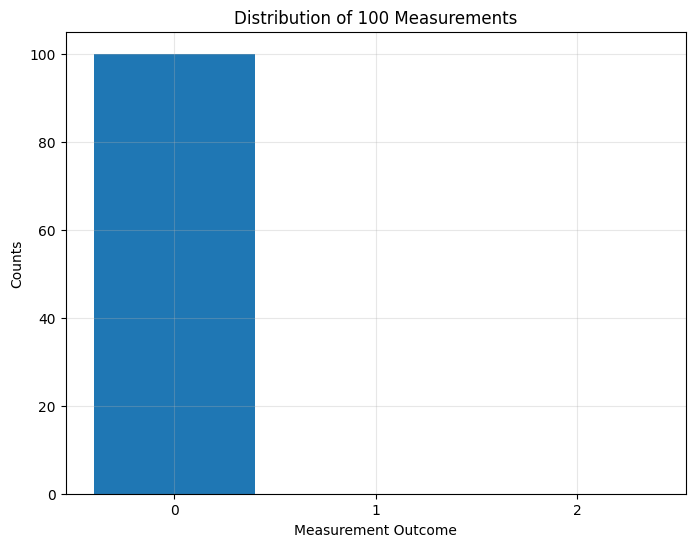

Mean: 0.00
Distribution of outcomes:
  |0⟩: 100 times (100.0%)
  |1⟩: 0 times (0.0%)
  |2⟩: 0 times (0.0%)


In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Get the measurement data for key "x"
measurement_data = results.measurements['x']

# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(measurement_data, bins=np.arange(dim+1)-0.5, rwidth=0.8)
plt.xticks(range(dim))
plt.xlabel('Measurement Outcome')
plt.ylabel('Counts')
plt.title(f'Distribution of {len(measurement_data)} Measurements')
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f"Mean: {np.mean(measurement_data):.2f}")
print(f"Distribution of outcomes:")
for i in range(dim):
    count = np.sum(measurement_data == i)
    percentage = count/len(measurement_data)*100
    print(f"  |{i}⟩: {count} times ({percentage:.1f}%)")